### Interpretability of Random Forests for all regions.

File generated 9/25/2025 (hbd)

This file workson making the plots for each region based on predictions. 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt


import seaborn as sns # statistical data visualization

##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from geopy.distance import great_circle
import cartopy.crs as ccrs
from matplotlib.path import Path

In [2]:
##import files to make the plots
from PredictionPlots import extrapolate
from PredictionPlots import daily_anomaly

from PredictionPlots import preprocess_ellipse
from PredictionPlots import BWcheckevent_label
from PredictionPlots import CScheckevent_label

from PredictionPlots import BWplot
from PredictionPlots import GPH_horzCS
from PredictionPlots import Temp_horzCS

In [3]:
##set up input file 
shift = 20
idx = 129 #129 for 20, 119 for 30.

input_metrics = np.empty((62,idx,8))
input = preprocess_ellipse(input_metrics,shift,idx)
input

Load data...
Remove leap year and shift data...
Test wind shape: (62, 129)
 
Removing NaNs ...
Returning final input array.


array([[[ 2.82750587e+01,  1.73300495e+00,  8.43285732e+01, ...,
          9.49809342e+01,  8.72442487e+00,  9.00467140e-03],
        [ 2.53026237e+01,  1.74360404e+00,  8.04039397e+01, ...,
          9.18773565e+01,  3.23886030e+00, -1.48809462e-01],
        [ 2.42979488e+01,  1.92930625e+00,  7.70881349e+01, ...,
          9.02635162e+01,  2.49161498e+00, -2.34117880e-01],
        ...,
        [ 3.64532700e+01,  1.16159156e+00,  8.47183391e+01, ...,
          1.01121249e+02, -1.76261679e+02, -9.05063548e-02],
        [ 3.44312019e+01,  1.11208075e+00,  8.42274559e+01, ...,
          8.22851492e+01, -1.60331940e+02, -2.14183384e-02],
        [ 3.29570198e+01,  1.24538832e+00,  8.47493430e+01, ...,
          8.39051194e+01, -1.35024313e+02, -4.18648642e-02]],

       [[ 1.06143017e+01,  1.28302587e+00,  7.07354718e+01, ...,
          1.33077608e+02,  7.21171264e+01, -2.47115777e-01],
        [ 1.11356401e+01,  1.31495918e+00,  7.00575733e+01, ...,
          1.29456793e+02,  4.43596923e

In [4]:
#separate input file py region based on feature selection
##Europe
eur_input = np.empty((62,idx,4))
eur_metrics_list = ["Geopotential Height (m)","Central Latitude ($^o$)",
                    "Central Longitude ($^o$)","Zonal-Mean Wind (m/s)"]
eur_input[:,:,0] = input[:,:,6]
eur_input[:,:,1] = input[:,:,2]
eur_input[:,:,2] = input[:,:,3]
eur_input[:,:,3] = input[:,:,0]

##Canada
canada_input = np.empty((62,idx,4))
canada_metrics_list = ["Geopotential Height (m)","Zonal-Mean Wind (m/s)",
                       "PV (K·m$^2$·s$^-1$·kg$^-1$)","Central Latitude ($^o$)"]
canada_input[:,:,0] = input[:,:,6]
canada_input[:,:,1] = input[:,:,0]
canada_input[:,:,2] = input[:,:,7]
canada_input[:,:,3] = input[:,:,2]

##SEUS
seus_input = np.empty((62,idx,4))
seus_metrics_list = ["Size ( *10$^7$m)","Zonal-Mean Wind (m/s)",
                     "Central Latitude ($^o$)","PV (K·m$^2$·s$^-1$·kg$^-1$)"]
seus_input[:,:,0] = input[:,:,4]
seus_input[:,:,1] = input[:,:,0]
seus_input[:,:,2] = input[:,:,2]
seus_input[:,:,3] = input[:,:,7]

In [5]:
##open index files for models
##Europe
infile = open("./index/posXtest_eur14.p", 'rb') 
eur_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_eur14.p", 'rb') 
eur_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_eur14.p", 'rb') 
eur_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_eur14.p", 'rb') 
eur_Fneg = pickle.load(infile)
infile.close()

##Canada
infile = open("./index/posXtest_can14.p", 'rb') 
can_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_can14.p", 'rb') 
can_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_can14.p", 'rb') 
can_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_can14.p", 'rb') 
can_Fneg = pickle.load(infile)
infile.close()

##SEUS
infile = open("./index/posXtest_seu14.p", 'rb') 
seu_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_seu14.p", 'rb') 
seu_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_seu14.p", 'rb') 
seu_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_seu14.p", 'rb') 
seu_Fneg = pickle.load(infile)
infile.close()

In [6]:
infile = open("../../data/gph/1959composite_capGPH10.p","rb")
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
gph_input = np.delete(gph_input,[151],1)
GPH = gph_input[52:62, 19+shift:168, :, :].reshape((10, idx, 26, 180)) 
infile.close()

infile = open("../../data/gph/1959anom_capGPH10.p","rb")
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
gph_input = np.delete(gph_input,[151],1)
GPHA = gph_input[52:62, 19+shift:168, :, :].reshape((10, idx, 26, 180))
infile.close()

print("GPH shape: ",GPH.shape)

GPH shape:  (10, 129, 26, 180)


In [7]:
infile = open("../../data/NH_tempanoms_Nov90-40.p","rb",)
temp_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
TEMP = temp_input[52:62, shift:, :, :].reshape((10, idx, 26, 180))
infile.close()

In [8]:
lat = np.arange(90, 38, -2)
print("Len (90-40) Latitudes: ", len(lat))
lat2 = np.arange(90, 18, -2)
print("Len (90-20) Latitudes: ", len(lat2))
lon = np.arange(0, 362, 2)
print("Len longitudes: ", len(lon))
lev = np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70., 100., 125., 150., 175., 200., 225., 250., 300., 350., 400., 
                450., 500., 550., 600., 650., 700., 750., 775., 800., 825., 850., 875., 900., 925., 950., 975., 1000.])
print("Len levels: ", len(lev))

Len (90-40) Latitudes:  26
Len (90-20) Latitudes:  36
Len longitudes:  181
Len levels:  37


## Plot!

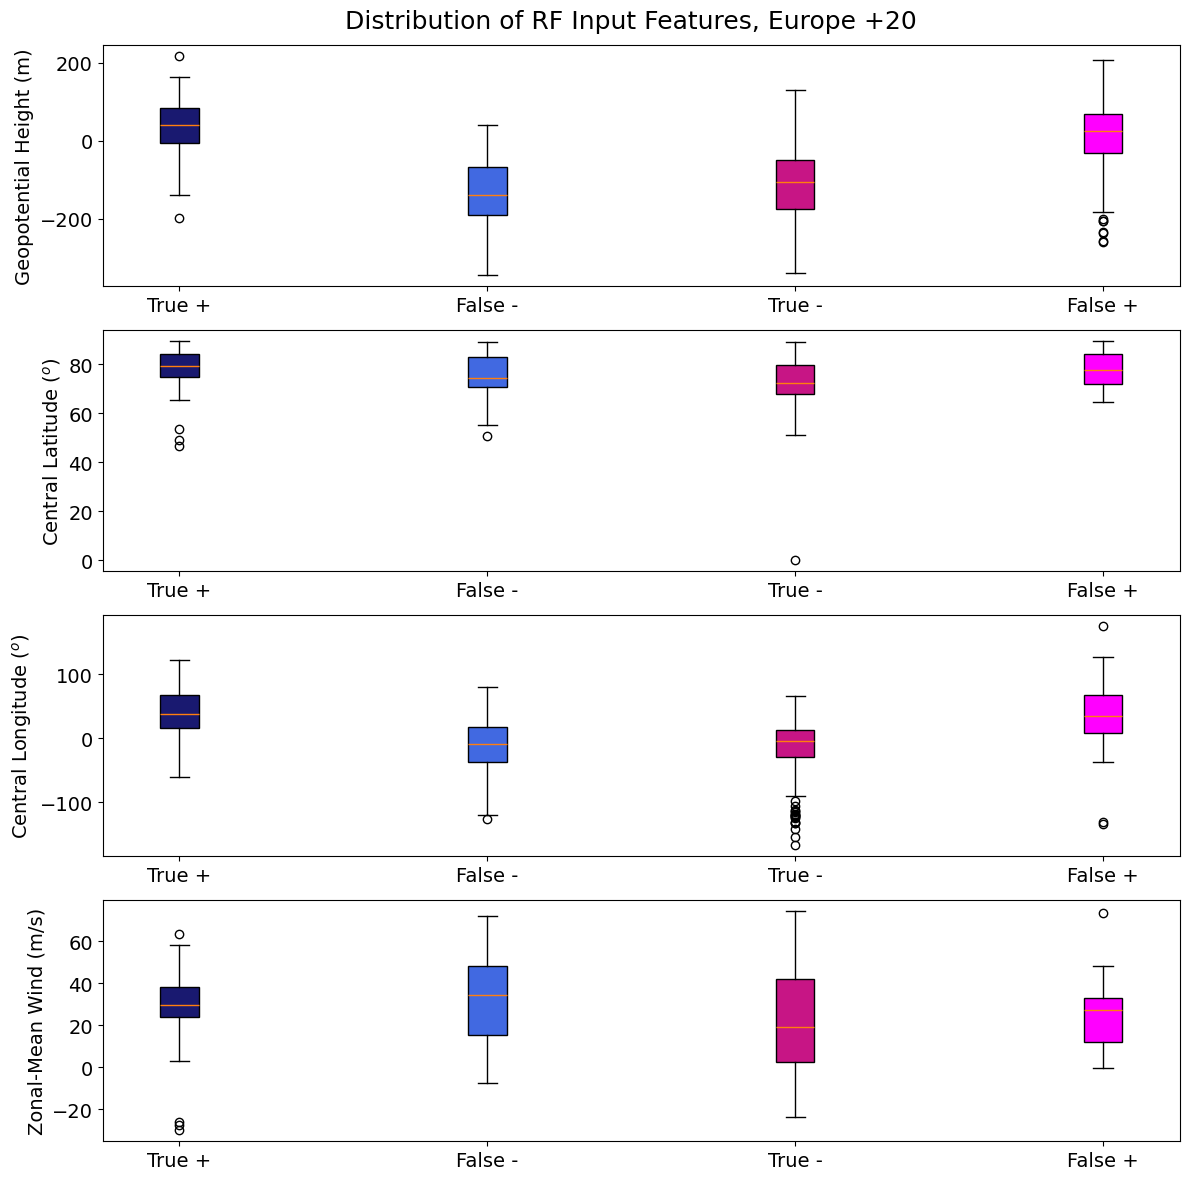

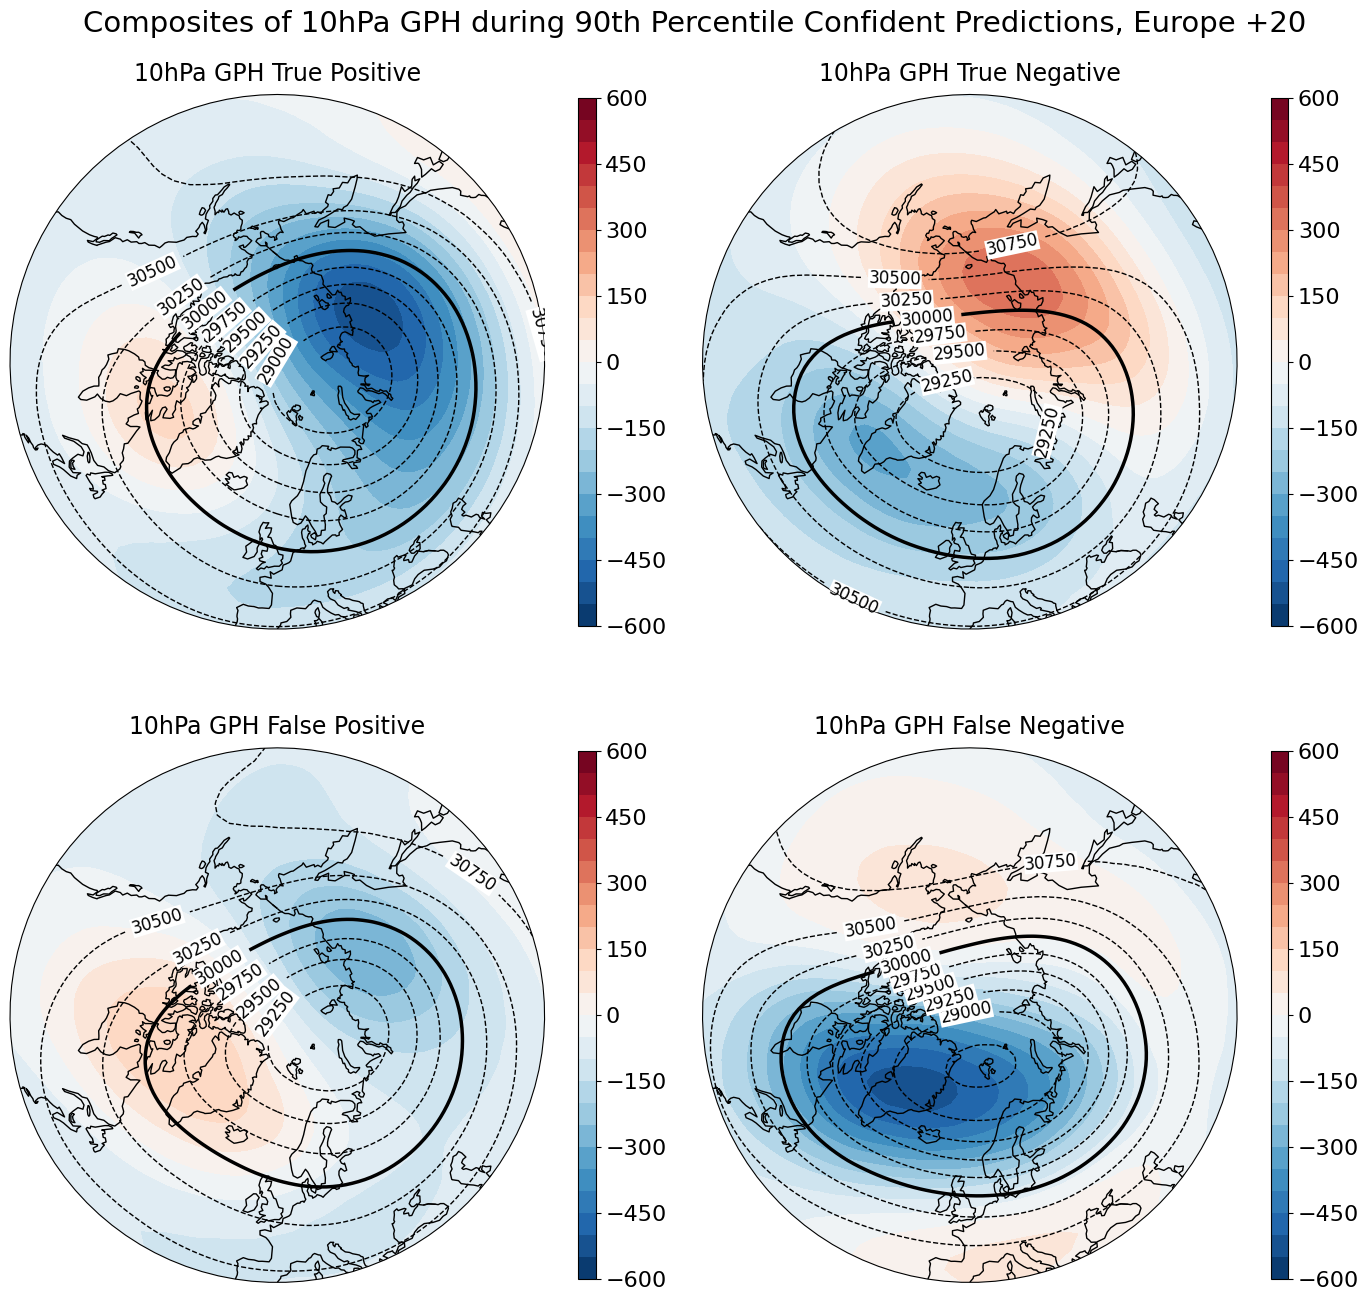

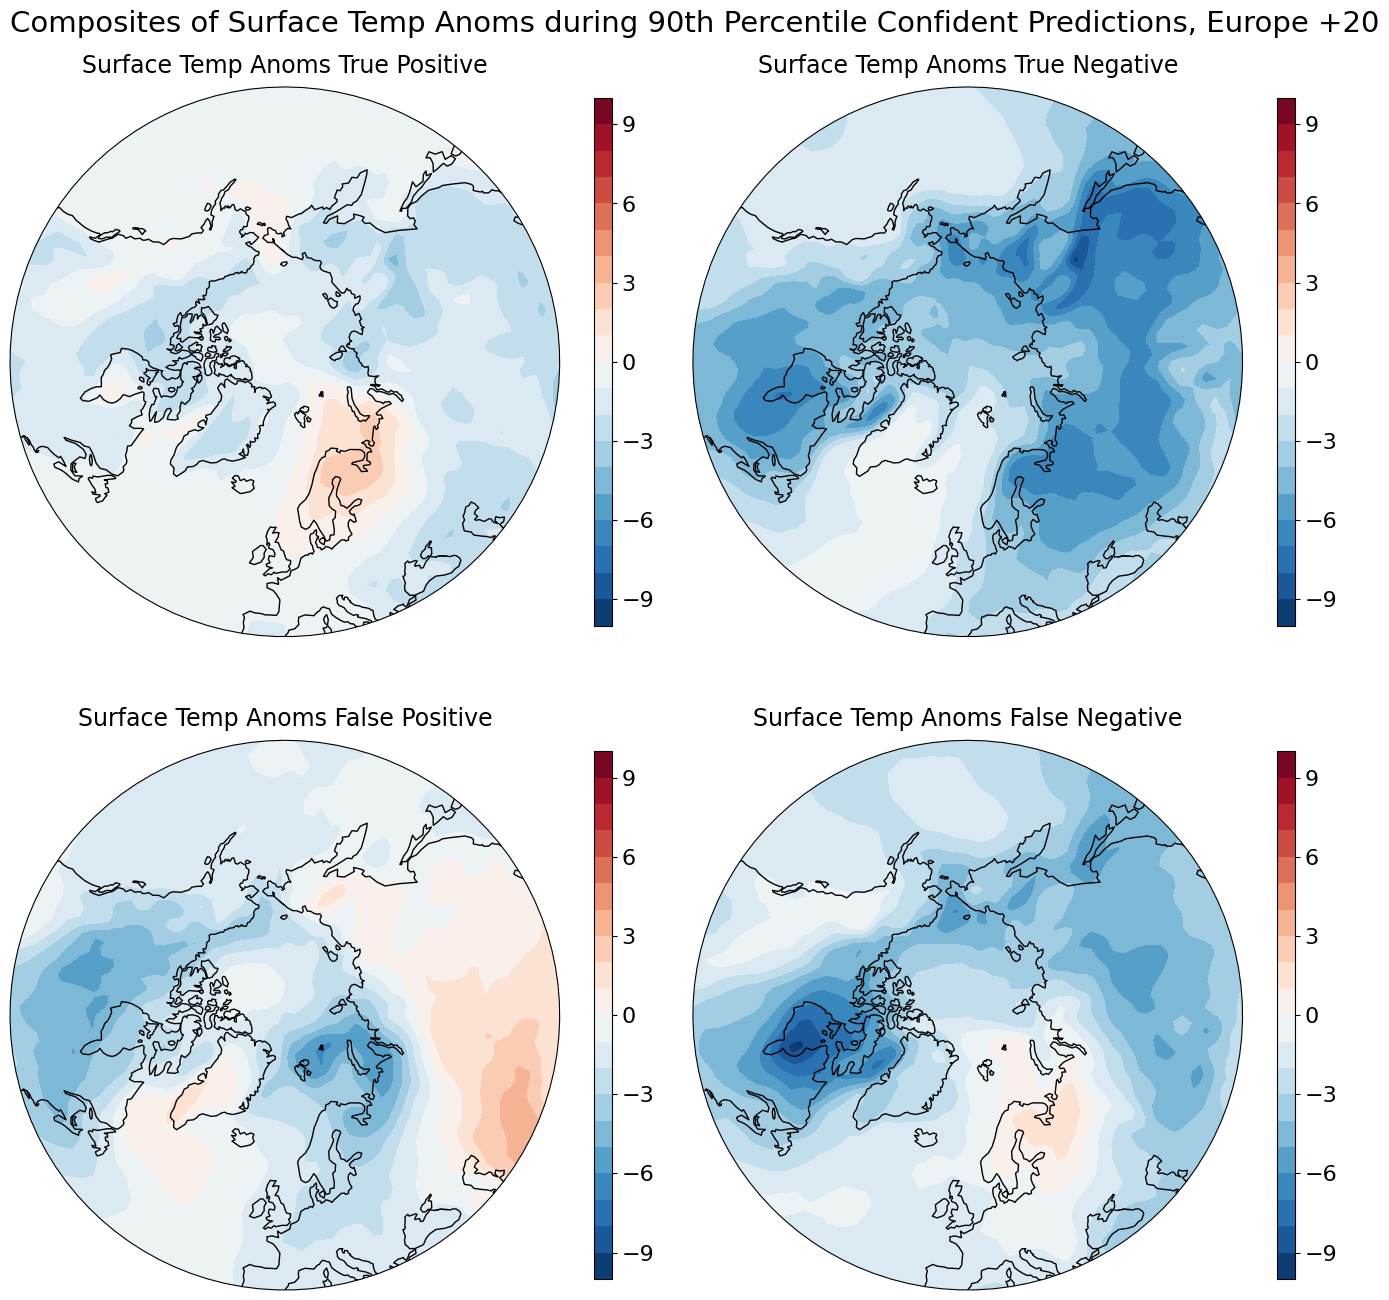

In [9]:
##Europe

##Box and Whisker Plot Europe +14
Tpos = BWcheckevent_label(eur_pos,eur_input,idx)
Tneg = BWcheckevent_label(eur_neg,eur_input,idx)
Fpos = BWcheckevent_label(eur_Fpos,eur_input,idx)
Fneg = BWcheckevent_label(eur_Fneg,eur_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,eur_metrics_list,"Europe +20","./images/eurBW_20.png")

##GPH Cross Section
GPH_cpos = CScheckevent_label(eur_pos,GPH,idx)
GPH_cneg = CScheckevent_label(eur_neg,GPH,idx)
GPH_Fpos = CScheckevent_label(eur_Fpos,GPH,idx)
GPH_Fneg = CScheckevent_label(eur_Fneg,GPH,idx)
GPHA_cpos = CScheckevent_label(eur_pos,GPHA,idx)
GPHA_cneg = CScheckevent_label(eur_neg,GPHA,idx)
GPHA_Fpos = CScheckevent_label(eur_Fpos,GPHA,idx)
GPHA_Fneg = CScheckevent_label(eur_Fneg,GPHA,idx)

GPH_horzCS(GPH_cpos,GPH_cneg,GPH_Fpos,GPH_Fneg,GPHA_cpos,GPHA_cneg,GPHA_Fpos,GPHA_Fneg,
               -600,600,50," Europe +20", lat, lon,"./images/eurGPHhorz_20.png")

##Temp Cross Section
TEMP_cpos = CScheckevent_label(eur_pos,TEMP,idx)
TEMP_cneg = CScheckevent_label(eur_neg,TEMP,idx)
TEMP_Fpos = CScheckevent_label(eur_Fpos,TEMP,idx)
TEMP_Fneg = CScheckevent_label(eur_Fneg,TEMP,idx)

Temp_horzCS(TEMP_cpos,TEMP_cneg,TEMP_Fpos,TEMP_Fneg, ", Europe +20", lat, lon, 
            "./images/eurTEMPhorz_20.png", -10,10,1)            

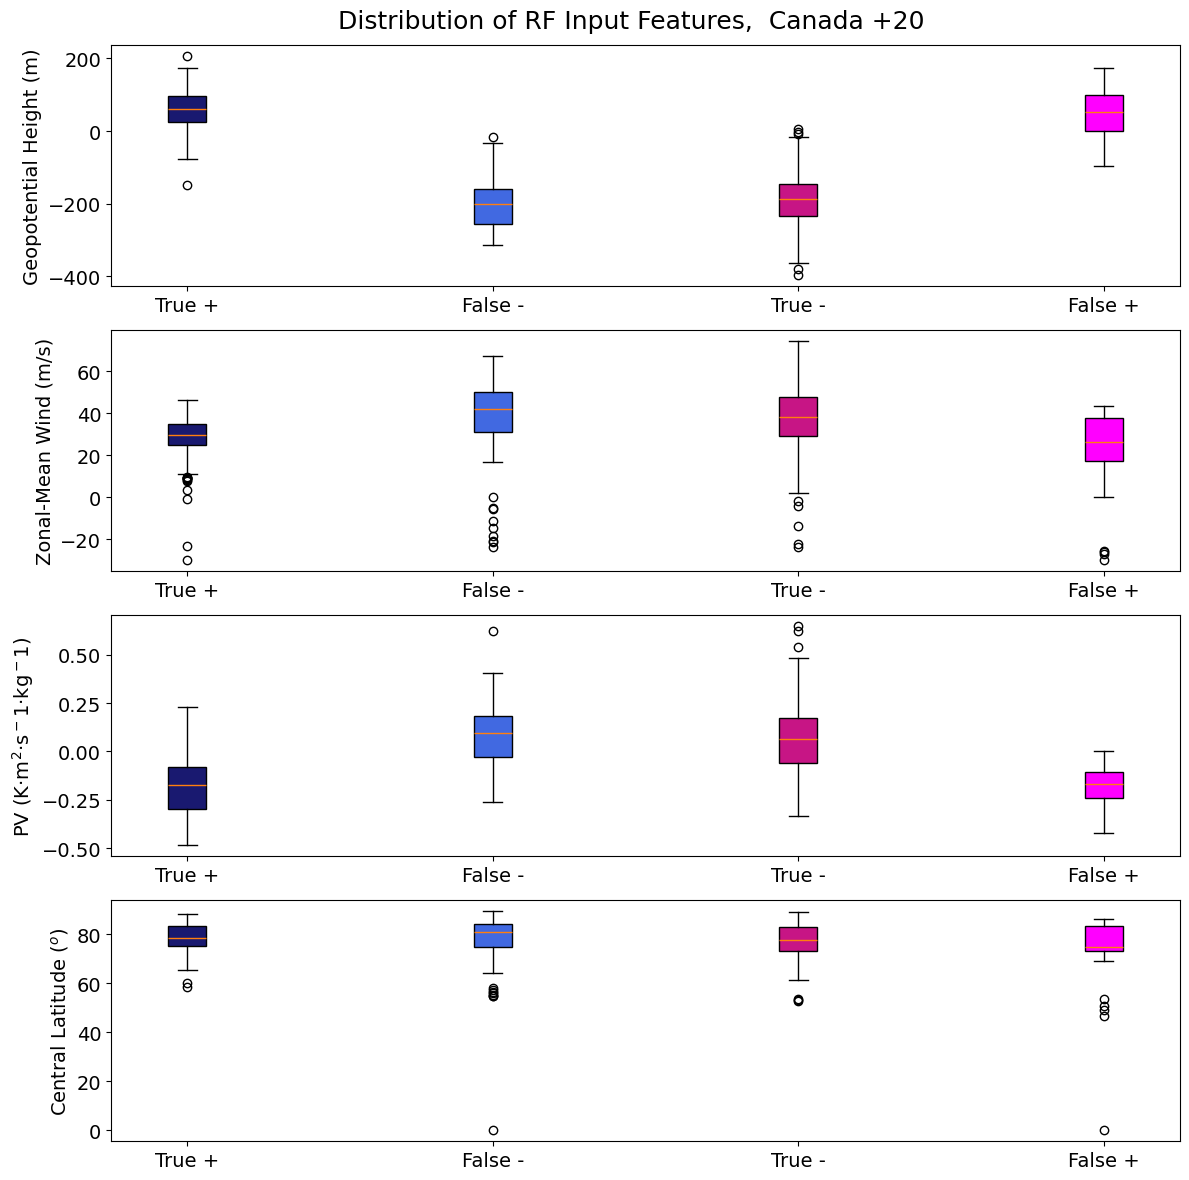

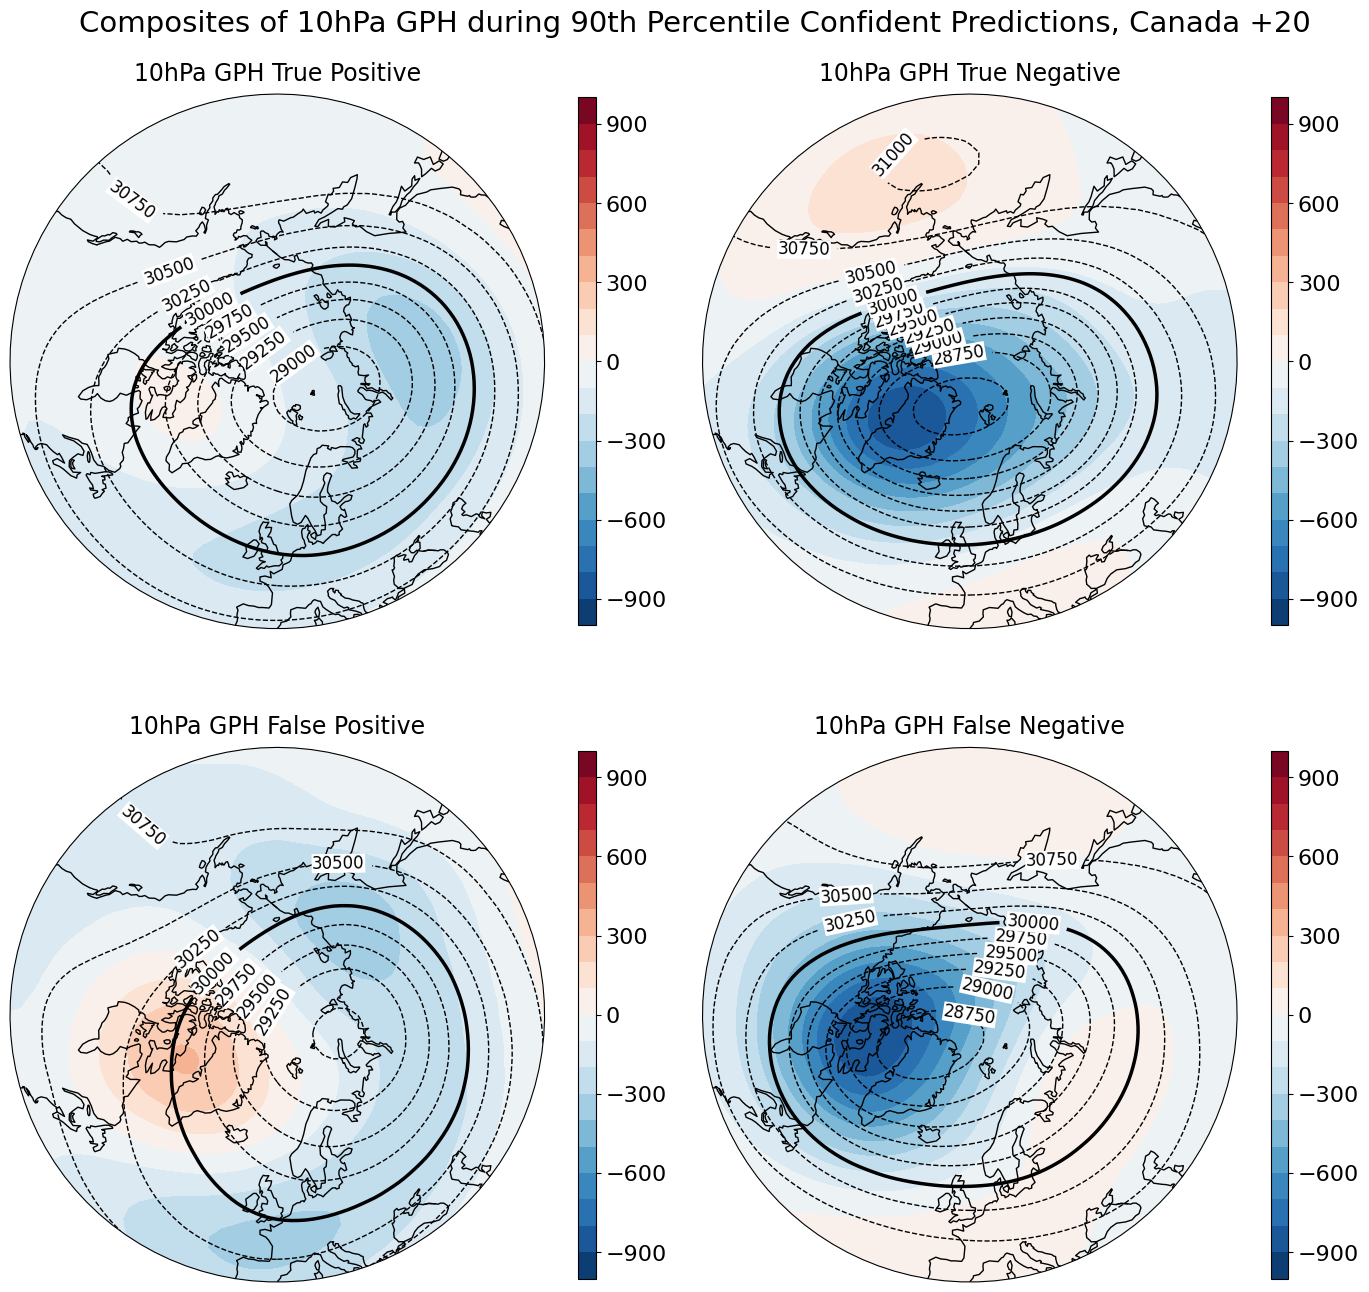

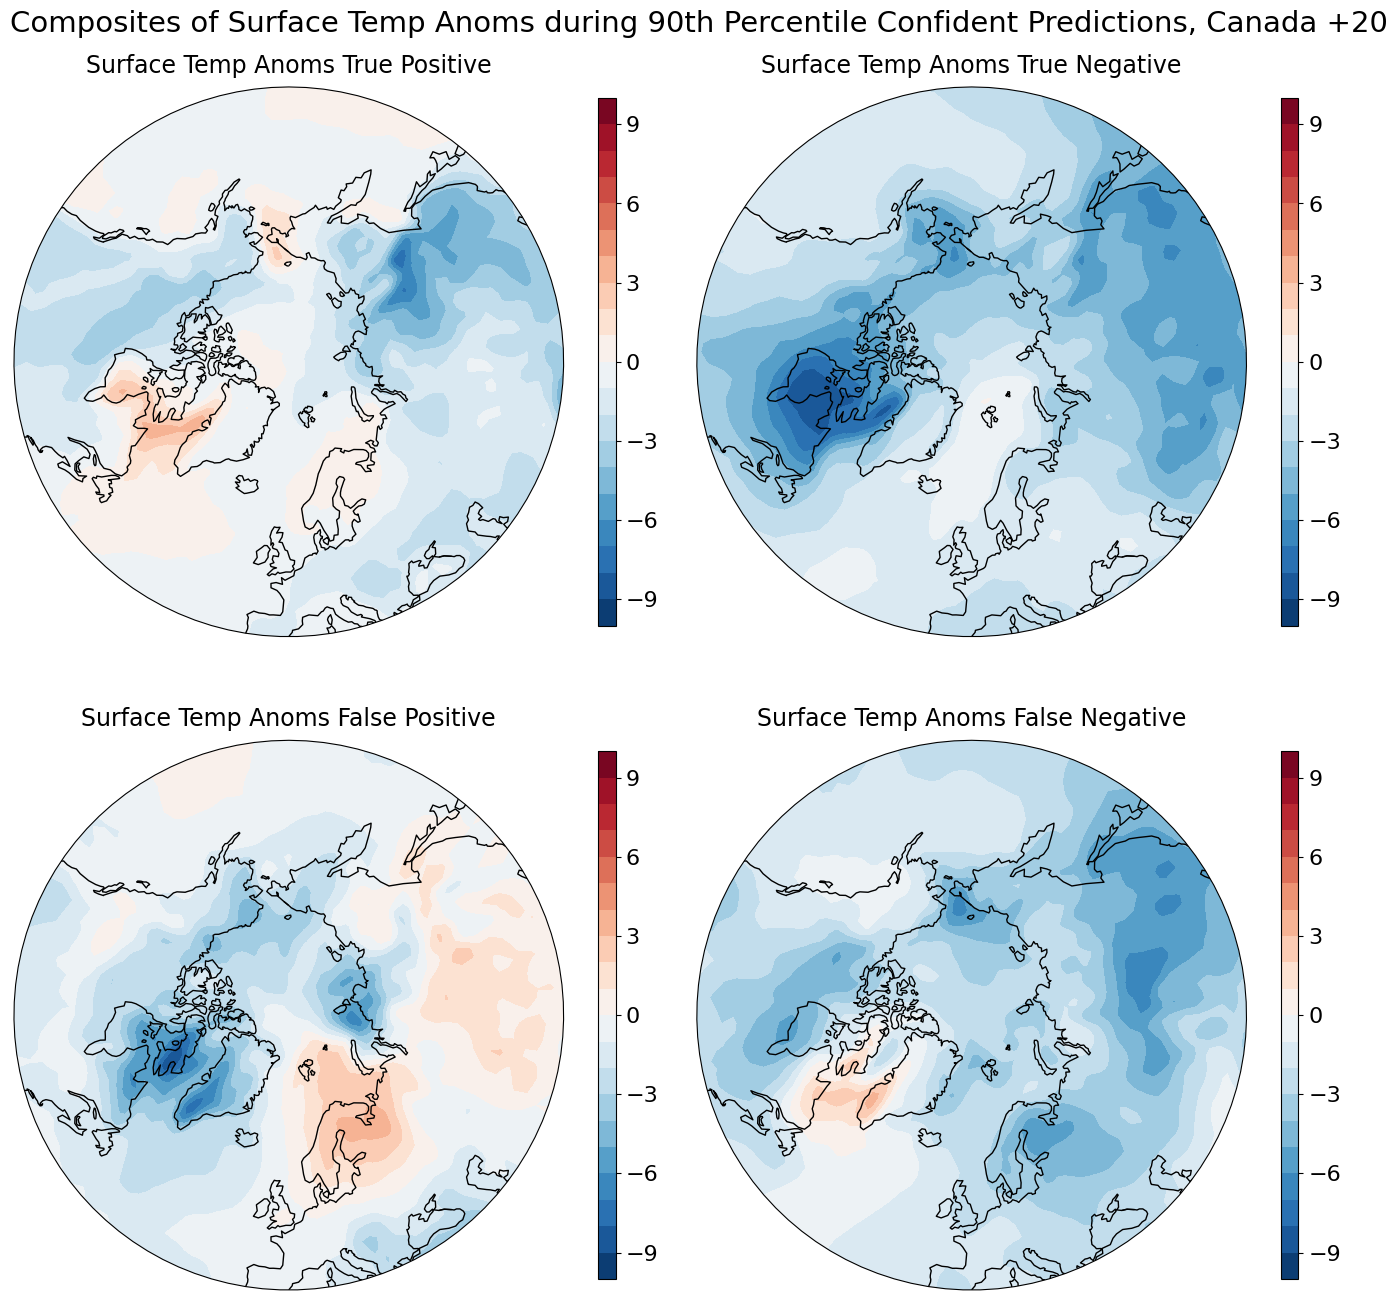

In [10]:
##Canada

##Box and Whisker Plot Canada +14
Tpos = BWcheckevent_label(can_pos,canada_input,idx)
Tneg = BWcheckevent_label(can_neg,canada_input,idx)
Fpos = BWcheckevent_label(can_Fpos,canada_input,idx)
Fneg = BWcheckevent_label(can_Fneg,canada_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,canada_metrics_list," Canada +20","./images/canBW_20.png")

##GPH Cross Section
GPH_cpos = CScheckevent_label(can_pos,GPH,idx)
GPH_cneg = CScheckevent_label(can_neg,GPH,idx)
GPH_Fpos = CScheckevent_label(can_Fpos,GPH,idx)
GPH_Fneg = CScheckevent_label(can_Fneg,GPH,idx)
GPHA_cpos = CScheckevent_label(can_pos,GPHA,idx)
GPHA_cneg = CScheckevent_label(can_neg,GPHA,idx)
GPHA_Fpos = CScheckevent_label(can_Fpos,GPHA,idx)
GPHA_Fneg = CScheckevent_label(can_Fneg,GPHA,idx)

GPH_horzCS(GPH_cpos,GPH_cneg,GPH_Fpos,GPH_Fneg,GPHA_cpos,GPHA_cneg,GPHA_Fpos,GPHA_Fneg,
               -1000,1000,100," Canada +20", lat, lon,"./images/canGPHhorz_20.png")

##Temp Cross Section
TEMP_cpos = CScheckevent_label(can_pos,TEMP,idx)
TEMP_cneg = CScheckevent_label(can_neg,TEMP,idx)
TEMP_Fpos = CScheckevent_label(can_Fpos,TEMP,idx)
TEMP_Fneg = CScheckevent_label(can_Fneg,TEMP,idx)

Temp_horzCS(TEMP_cpos,TEMP_cneg,TEMP_Fpos,TEMP_Fneg, ", Canada +20", lat, lon, 
            "./images/canTEMPhorz_20.png", -10,10,1)           

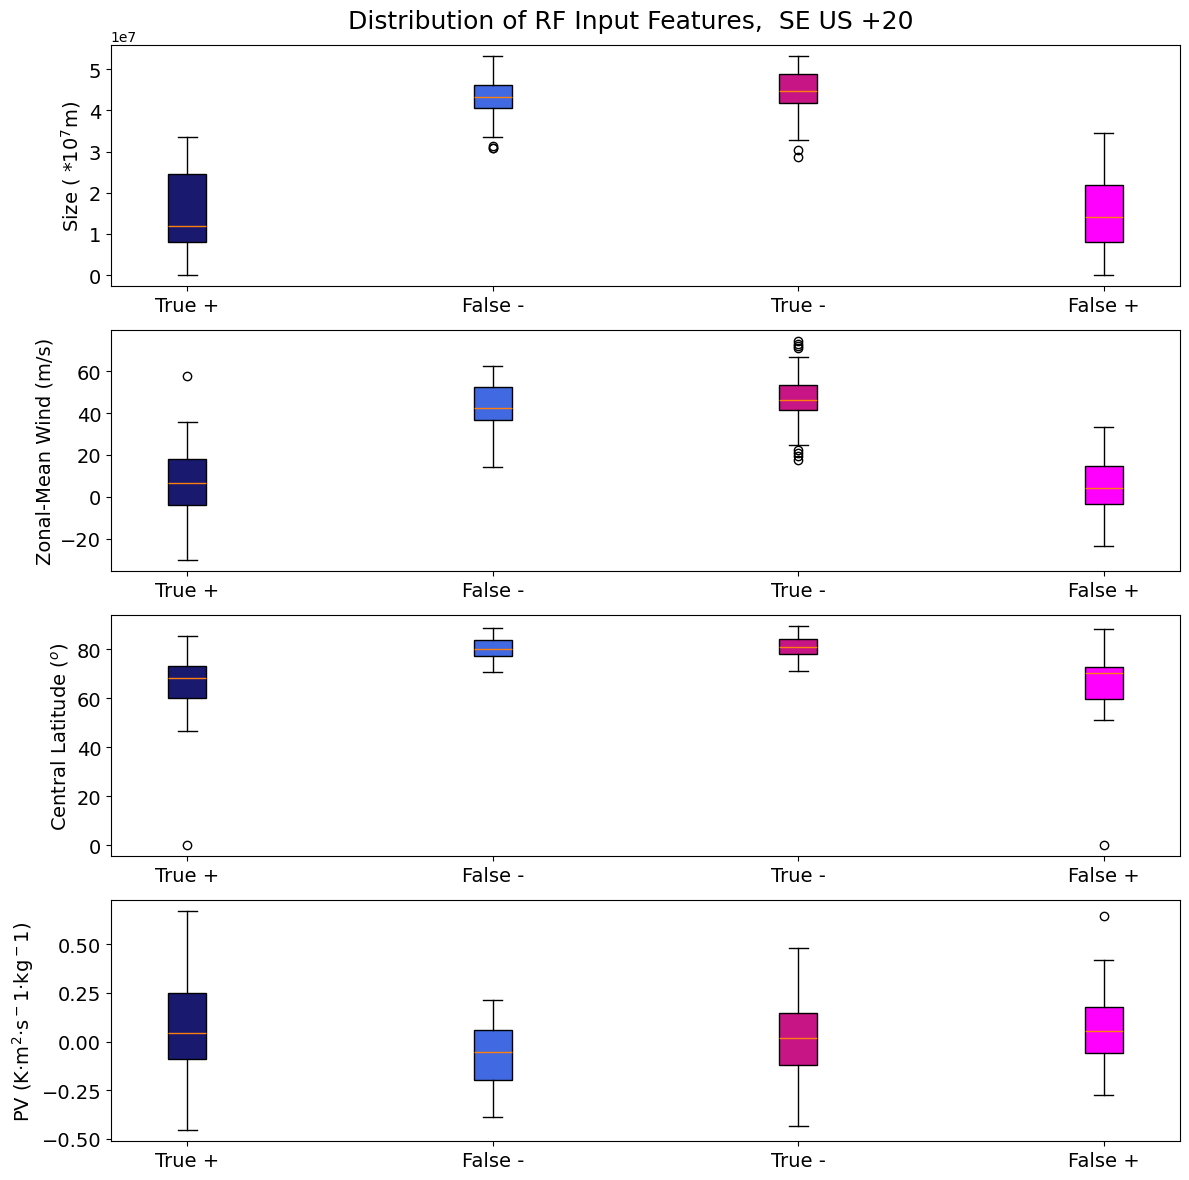

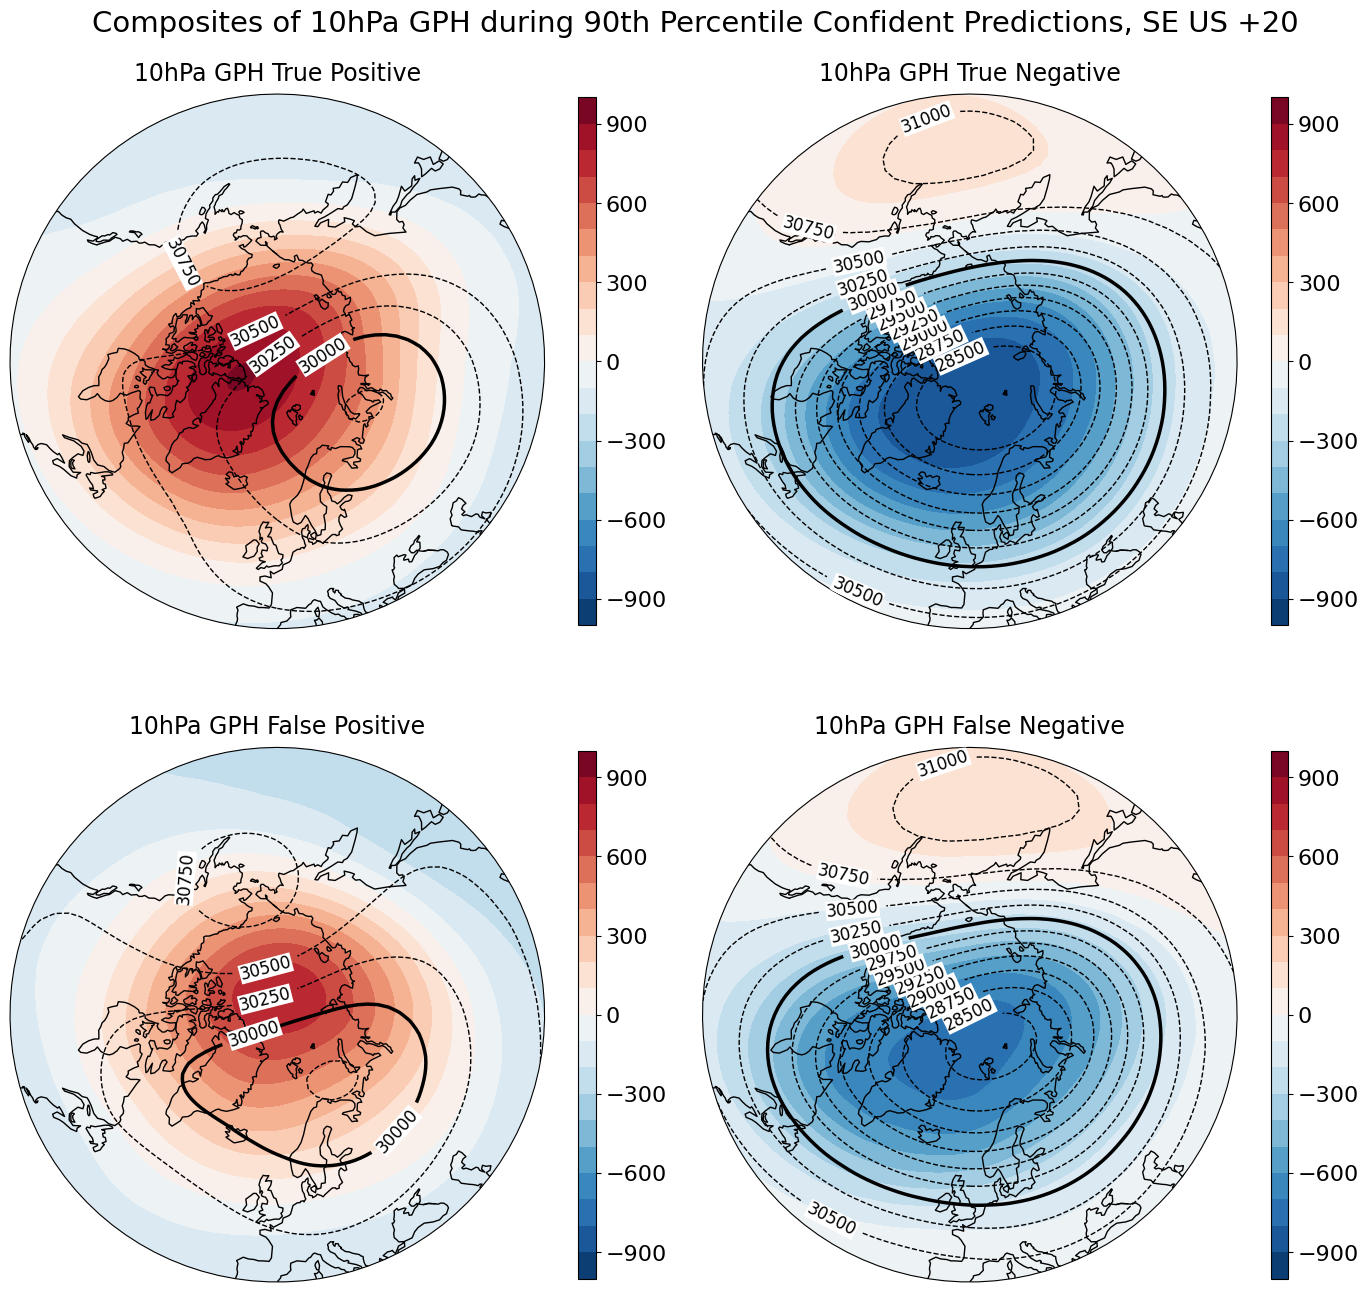

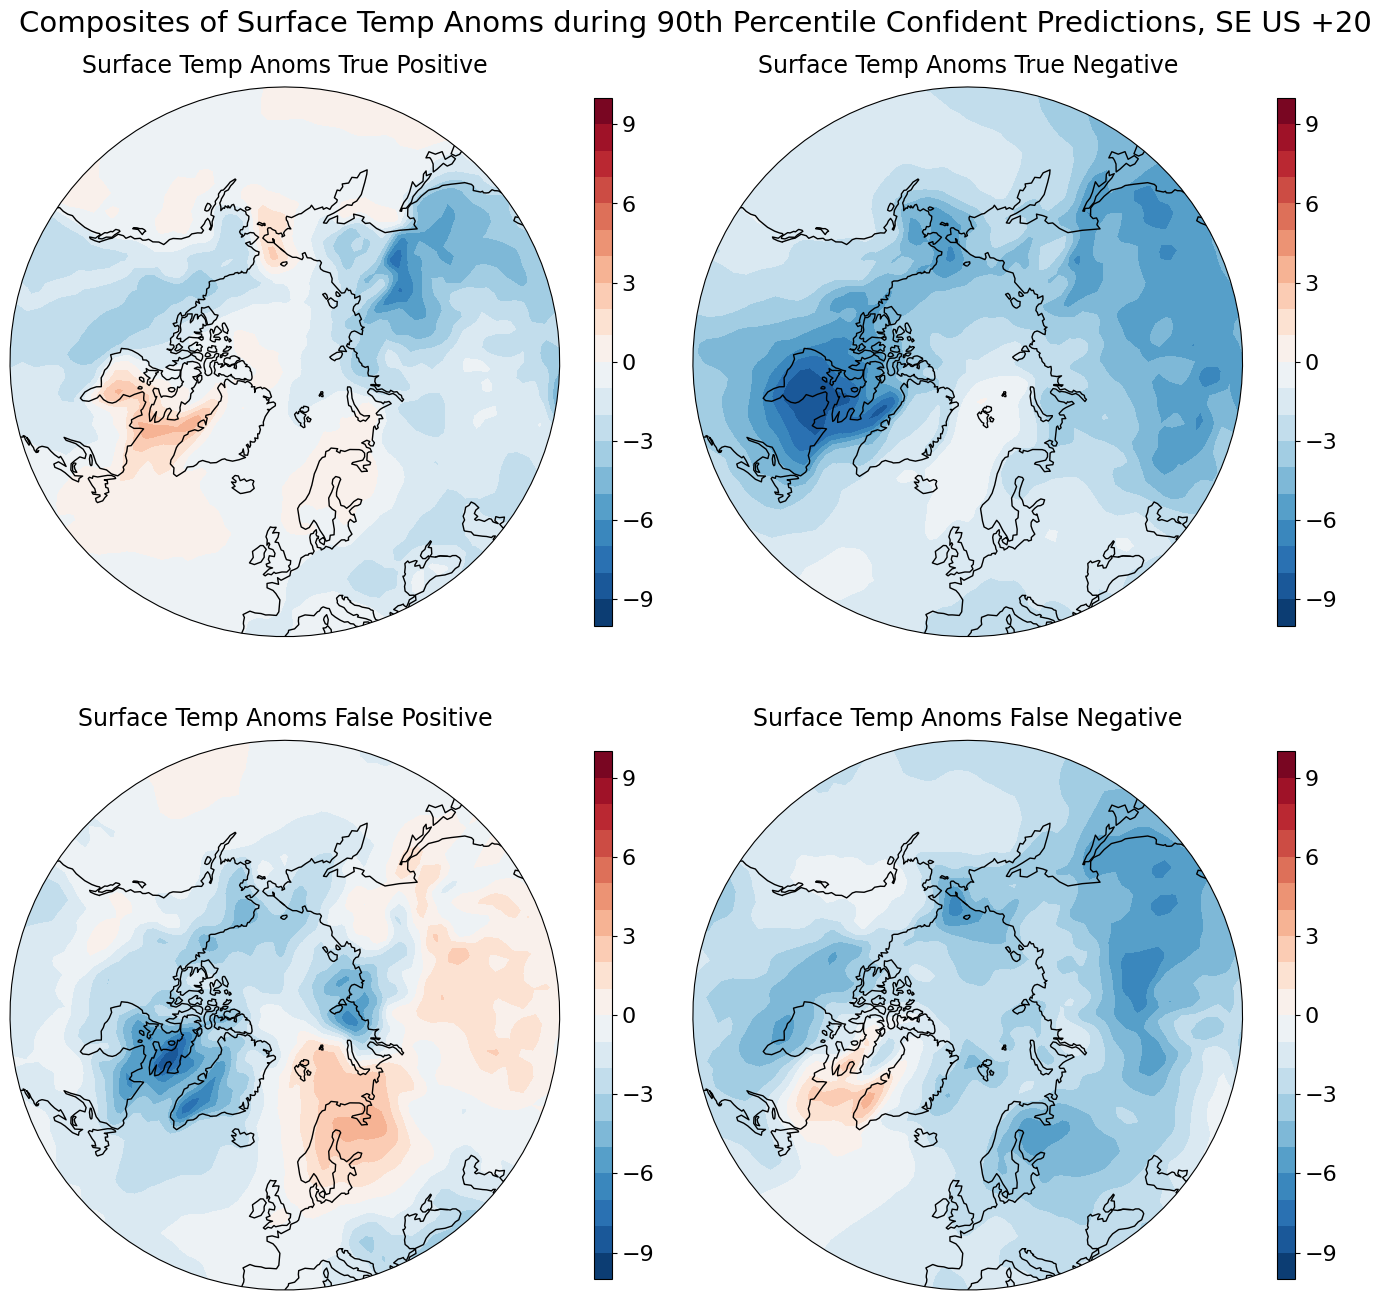

In [11]:
##SE US

##Box and Whisker Plot Canada +14
Tpos = BWcheckevent_label(seu_pos,seus_input,idx)
Tneg = BWcheckevent_label(seu_neg,seus_input,idx)
Fpos = BWcheckevent_label(seu_Fpos,seus_input,idx)
Fneg = BWcheckevent_label(seu_Fneg,seus_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,seus_metrics_list," SE US +20","./images/seuBW_20.png")

##GPH Cross Section
GPH_cpos = CScheckevent_label(seu_pos,GPH,idx)
GPH_cneg = CScheckevent_label(seu_neg,GPH,idx)
GPH_Fpos = CScheckevent_label(seu_Fpos,GPH,idx)
GPH_Fneg = CScheckevent_label(seu_Fneg,GPH,idx)
GPHA_cpos = CScheckevent_label(seu_pos,GPHA,idx)
GPHA_cneg = CScheckevent_label(seu_neg,GPHA,idx)
GPHA_Fpos = CScheckevent_label(seu_Fpos,GPHA,idx)
GPHA_Fneg = CScheckevent_label(seu_Fneg,GPHA,idx)

GPH_horzCS(GPH_cpos,GPH_cneg,GPH_Fpos,GPH_Fneg,GPHA_cpos,GPHA_cneg,GPHA_Fpos,GPHA_Fneg,
               -1000,1000,100," SE US +20", lat, lon,"./images/seuGPHhorz_20.png")

##Temp Cross Section
TEMP_cpos = CScheckevent_label(can_pos,TEMP,idx)
TEMP_cneg = CScheckevent_label(can_neg,TEMP,idx)
TEMP_Fpos = CScheckevent_label(can_Fpos,TEMP,idx)
TEMP_Fneg = CScheckevent_label(can_Fneg,TEMP,idx)

Temp_horzCS(TEMP_cpos,TEMP_cneg,TEMP_Fpos,TEMP_Fneg, ", SE US +20", lat, lon, 
            "./images/seuTEMPhorz_20.png", -10,10,1)           